### Initial Setup

In [1]:
import os, sys, re
import pprint as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget
%matplotlib inline

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)

sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter')

### Create graphing function

In [3]:
def get_categories(
    in_df, 
    category_rgx,
    unit_rgx,
    filter_column_name = "name", 
    filter_column_units = "units",
    numeric_column = "value"):
    metrics_s = {
        (i, j) for i,j in zip(in_df[filter_column_name], in_df[filter_column_units]) 
        if 
            (match:=re.search(category_rgx, i, re.IGNORECASE))
            and (match:=re.search(unit_rgx, j, re.IGNORECASE)) 
    }

    df = in_df.loc[
        (
            in_df[filter_column_name].isin(
                [i for i, j in metrics_s])
        )].copy()

    df[numeric_column] = df[[numeric_column,]].apply(pd.to_numeric, errors='coerce', axis=1)
    df = df\
        .replace({
            "NA":np.nan
        }).astype(
        {
            numeric_column:"float64",
            "date":"datetime64[ns]"
        }
    )
    df = df.loc[(~(pd.isna(df[numeric_column])))].copy()
    plot_d = {
        'df': df,
        'groups' : [re.match(r'^[^,]+', i).group(0) for i in df["name"]],
        'data_col' : numeric_column,
        'metrics_s' : metrics_s
    }
    
    return  plot_d

### Process Data

Here we will load the ETL pre-processed data and plot it to ensure it makes sense.  In this check, we look at the net generation categories so that they can be used for a time series analysis.  The 'All Sectors' groups appear to be intact for the entire recorded history while there are missing inputs in some of the others.

In [2]:
total_energy_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/TotalEnergyDF")\
    .select("name", "date", "units", "value")\
    .toPandas()

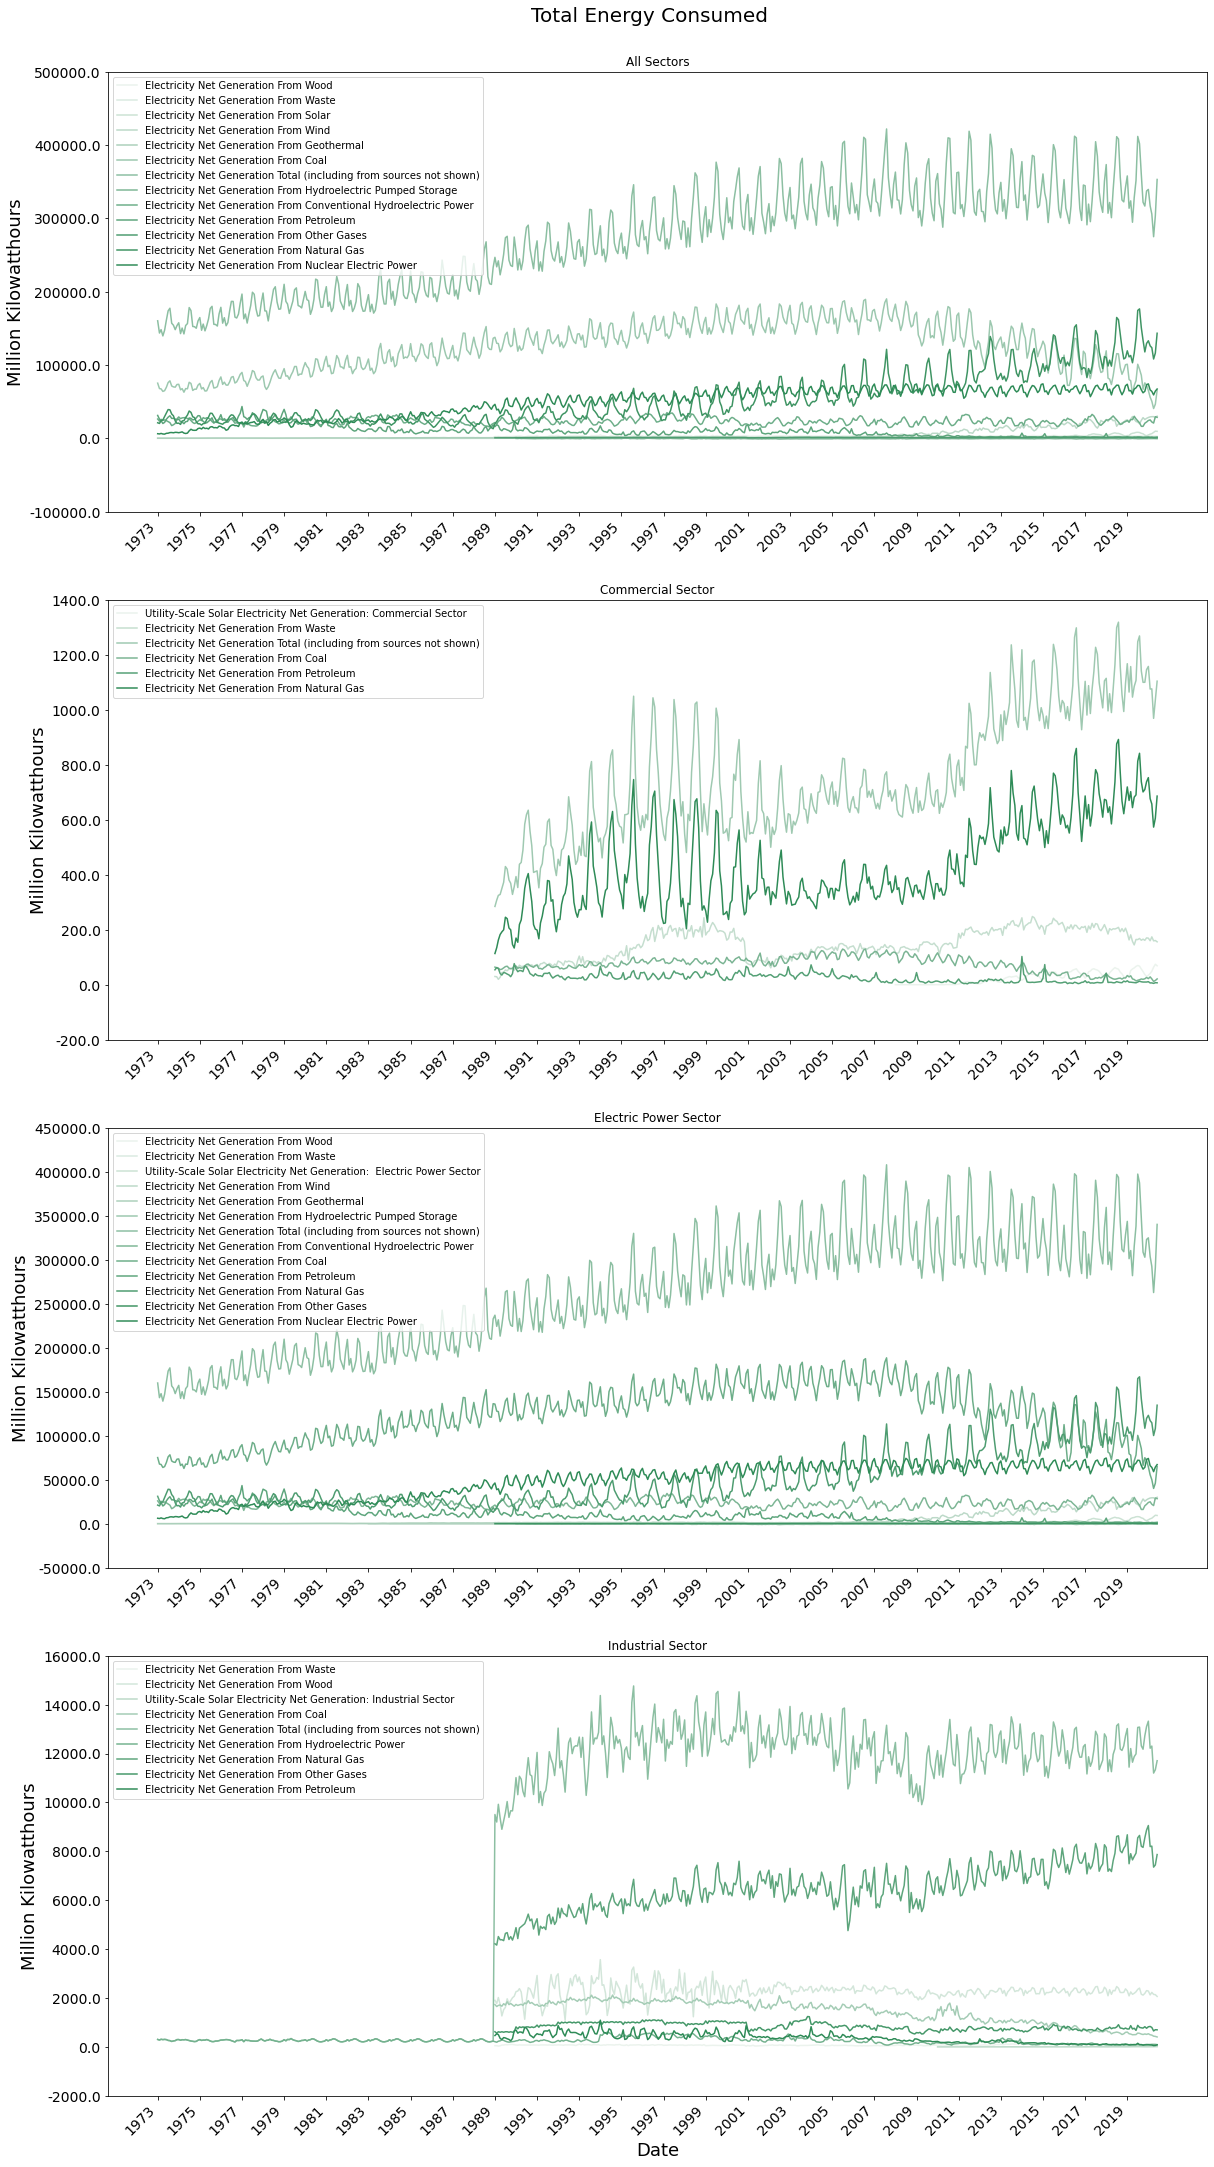

In [70]:
plot_input_l = []
for c_rgx, u_rgx, title in (
    ["(?=Net Generation).*(All Sectors)$", "Million Kilowatthours", "All Sectors"],
    ["(?=Net Generation).*(Commercial Sector)$", "Million Kilowatthours", "Commercial Sector"],
    ["(?=Net Generation).*(Electric Power Sector)$", "Million Kilowatthours", "Electric Power Sector"],
    ["(?=Net Generation).*(Industrial Sector)$", "Million Kilowatthours", "Industrial Sector"],):    
    plot_d = get_categories(
        in_df = total_energy_df, 
        category_rgx = c_rgx,
        unit_rgx = u_rgx)
    plot_d['date_col'] = 'date'
    plot_d['date_fmt'] = "%Y"
    plot_d['palette'] = sns.light_palette(
            "seagreen", 
            n_colors=len(set(plot_d['groups'])))
    plot_d['title'] = title
    plot_input_l.append(plot_d)
    
font_scale = 1
fig, axs = plt.subplots(len(plot_input_l), 1, figsize=(16,30), sharex=True)
fig.tight_layout()
plt.subplots_adjust(top = 0.95, hspace = 0.2)

for ax, p_d in zip(axs, plot_input_l):
    ax = sns.lineplot(
        data = p_d["df"],
        x = p_d["df"][p_d["date_col"]],
        y = p_d["df"][p_d["data_col"]],
        hue = p_d["groups"],
        ci = None,
        palette = p_d["palette"],
        ax = ax
    )
    ax.set_xlabel(
        "Date", 
        fontsize = 18 * font_scale)
    ax.set_ylabel(
        ", ".join(list({j for i, j in p_d['metrics_s']})),
        fontsize = 18 * font_scale)
    ax.set_xticks(p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist()[::2])
    ax.set_xticklabels(
        labels=p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist()[::2],
        rotation=45, 
        ha='right',
        fontsize = 14 * font_scale)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(
        labels = ax.get_yticks(),
        fontsize = 14 * font_scale)
    ax.set_title(p_d["title"])
    ax.xaxis.set_tick_params(which='both', labelbottom=True) #show ticks in all subplots (sharex turns it off)


fig.suptitle("Total Energy Consumed", fontsize = 20 * font_scale);